# GOAL OF THE PROJECT

**`Predict target feature first and foremost by geometrical parameters`**

# IMPORTING LIBRARIES

In [203]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm as cmaps
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import re
import seaborn as sns
from scipy import stats
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

print("Packages loaded!")

Packages loaded!


# Pipeline Controller

df = load_original_data()
df_cleaned = delete_unncessary_columns(df)
df_cleaned = make_columns_lowercase(df_cleaned)
df_cleaned = delete_non_legit_XDC_IDs(df_cleaned)
df_cleaned, date_columns = date_columns_transform_into_datetime(df_cleaned)
df_cleaned = delete_rows_with_nan_in_selected_cols(df_cleaned, ["schmelzen_datum", "ns1_datum"])
df_cleaned = substitute_familie_int_str(df_cleaned)
df_cleaned = add_date_month_string_columns(df_cleaned, date_columns)
df_cleaned = string_comma_to_dot_float(df_cleaned)
#df_cleaned = clean_personal_names(df_cleaned)

# READ DATA INTO DATAFRAME FROM EXISTING .CSV

In [272]:
def load_original_data():
    """
    Read production data and parse into pandas dataframe.
    """
    latest_file = r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\DA_Midterm_Project\_Data\Production_Data.csv"
    df_prod_whole = pd.read_csv(latest_file, sep=";", encoding = "ISO-8859-1")
    
    return df_prod_whole

df_prod_whole = load_original_data()

# DF CLEANING

## Make columns lowercase and fix syntax

In [205]:
def make_columns_lowercase(df):
    
    lower_cols = [i.lower().replace(" ", "_").replace("-", "_") for i in df.columns]
    df.columns = lower_cols    
    
    return df

df_cleaned = make_columns_lowercase(df_prod_whole)

## Remove rows with Nozzle-ID < `68.000`

In [206]:
def delete_rows_with_XDC_ID_pre_68k(df):
    """
    Delete all entries before XDC-ID 68.000 due to them having partially corrupted / wrong data.
    """
    
    df = df[df["pdc_nummer"]>=68000]
    
    return df

df_cleaned = delete_rows_with_XDC_ID_pre_68k(df_prod_whole)

## Delete unncessary/empty colums

In [207]:
print("Number of columns/features before dropping them: ", len(df_cleaned.columns))

Number of columns/features before dropping them:  195


In [208]:
def delete_unncessary_columns(df):
    """
    Delete columns only containing NaN values or columns with effectively useless data
    """
    #try:
    columns_to_drop = []    

    partial_col_strings_to_drop = ["datum", "wt1", "wt2", "ort", "geraet", "defekt", "charge",
                                  "kommentar", "offset", "uebergabe", "id", "kanal", "version",
                                  "coating", "versand", "shore", "linear", "auslenkung", "et2", "ft2",
                                  "schneiden", "schleifen", "assembl", "grenzwert", "personal"]

    for drop_col in partial_col_strings_to_drop:
        columns_to_drop.extend([col for col in df.columns if drop_col in col.lower()])

    columns_to_drop.extend(['versand_intern',
                             'ssma_timestamp',
                             'assembley_teflonschlauch_charge',
                             'pdc_nummer',
                             'dose', "ft1_typ", "ek_groesse"])
    
    df.drop(columns=columns_to_drop, inplace=True)

    #except:
        #raise ValueError("Deleting columns was unsuccessful!")
    
    return df

df_cleaned = delete_unncessary_columns(df_prod_whole)

In [209]:
print("Number of columns/features after dropping them: ", len(df_cleaned.columns))

Number of columns/features after dropping them:  29


## Drop unnecessary `Familie` type

Only keep one of the three product families. <br>
Family 3 is of a totally different kind, that's why they are dropped. <br>
Family 2 is a subcategory of 1, with comparable volumes but key differences in one core geometrical parameter; that's why only 1 is kept.

df_cleaned["Familie"]

In [210]:
def substitute_familie_int_str(df):
    """
    Only keep PDCs (1) // PDC-Cs 
    """
    
    df = df[(df["familie"]==1)]
        
    return df

df_cleaned = substitute_familie_int_str(df_cleaned)

## Turn string-comma-values into dot-float-values

In [211]:
def string_comma_to_dot_float(df):
    """
    Cast string-comma-values as dot-float-values
    """
    cols_to_use = ['ns1_winkel_vorne','ns1_winkel_hinten','ns1_durchmesser_vorne','ns1_durchmesser_hinten',
               "ns2_center_variation", "ns2_front_angle","ns2_curve","ns2_15xlength",
               "ns2_parabolic_factor","oeo_oeo", "piezo_phase"] 

    for column in cols_to_use:
        df[column] = [float(str(x).replace(',','.')) for x in df[column]] 
     
    return df

df_cleaned = string_comma_to_dot_float(df_cleaned)

## Clean personal (operator) initials

def clean_personal_names(df):
    """
    Func descr
    """
    
    replacements = {'GD': 'GDH',
                    'MFW': 'MFE',
                    "ME": "MFE",
                    "MF": "MFE",
                    "LAE": "AL",
                    "SF": "SFZ",
                    "DC": "AC",
                    "THANH": "TT",
                    "?": np.nan}
    
    personal_cols = [col for col in df_cleaned.columns if "personal" in col]
    
    for col in personal_cols:
        op_list = []

        for op in df_cleaned["ft1_personal"]:
            if type(op)==str and op.isalpha():
                op_list.append(op.upper())
            elif op=="?":
                op_list.append(np.nan)
            elif type(op)==str and "." in op:
                op_list.append(np.nan)
            elif type(op)==str and not op.isalpha() and op!="?":
                op_list.append(op[:re.search(r'\W+', op).start()].upper())
            else:
                op_list.append(np.nan)

        op_list = [replacements.get(word, word) for word in op_list]

        df[col] = op_list
        
    return df
    
#df_cleaned = clean_personal_names(df_cleaned)

In [212]:
df_cleaned

produktion_groesse  familie  art  ns1_winkel_vorne  ns1_winkel_hinten  \
0                     1.00        1    1              8.00              16.00   
1                     1.00        1    1              9.00              15.00   
2                     1.00        1    1             17.00              31.00   
3                     1.00        1    1              5.00              43.00   
4                     1.00        1    1             13.00               8.00   
...                    ...      ...  ...               ...                ...   
113022                1.00        1    1              9.60              16.60   
113023                1.00        1    1             14.00               6.40   
113024                1.00        1    1             29.50              34.40   
113025                1.00        1    8             28.00              11.00   
113026                1.00        1    7              3.40               8.20   

        ns1_durchmesser_vorne  ns1_durchmesser_hinten  ns2_center_variation  \
0                       70.10                   57.40                  0.15   
1                       70.00                   60.20                  0.36   
2                       69.90                   59.60                  0.43   
3                       68.80                   60.40                  0.39   
4                       69.60                   55.40                  0.00   
...                       ...                     ...                   ...   
113022                  64.93                   57.66                  0.45   
113023                  69.51                   59.41                  0.26   
113024                  70.39                   70.33                  1.70   
113025                  66.81                   58.48                  0.07   
113026                  65.27                   55.45                  0.18   

        ns2_front_angle  ns2_curve  ns2_15xlength  ns2_parabolic_factor  \
0                  0.25       1.40           5.78                 35.20   
1                  0.25       1.30           5.35                 33.00   
2                  0.68       1.10           5.46                 33.40   
3                  0.50       1.00           5.80                 33.50   
4                  0.00       0.00           0.00                  0.00   
...                 ...        ...            ...                   ...   
113022             0.64       1.30           5.58                 42.60   
113023             0.64       1.30           5.83                 41.30   
113024             1.18       1.40           6.49                 40.90   
113025             0.64       1.30           5.92                 40.50   
113026             0.33       1.20           5.45                 42.00   

        oeo_oeo  kleben1_kleber_teilentnahme  kleben2_kleber_teilentnahme  \
0          0.00                         0.00                         0.00   
1         53.35                         0.00                         0.00   
2         53.35                         0.00                         0.00   
3         49.88                         0.00                         0.00   
4          0.00                         0.00                         0.00   
...         ...                          ...                          ...   
113022    48.93                         0.00                         0.00   
113023    48.59                         0.00                         0.00   
113024     0.00                         0.00                         0.00   
113025    45.17                          NaN                          NaN   
113026    46.20                         0.00                         0.00   

        bqc_spannung  bqc_puls  bqc_volumen  et1_spannung  et1_puls  \
0                NaN       NaN          NaN           NaN       NaN   
1                NaN       NaN          NaN           NaN       NaN   
2                NaN       NaN          NaN    

## Rename different QC columns to generic form

def rename_qc_columns(df):
    """
    Func descr
    """
    
    df.rename(columns={'bqc_volumen': 'qc1_volumen', 
                         'et1_volumen': 'qc2_volumen',
                        'ft1_volumen': 'qc3_volumen',
                        'ek_volumen': 'qc4_volumen',

                        'bqc_spannung': 'qc1_spannung', 
                         'et1_spannung': 'qc2_spannung',
                        'ft1_spannung': 'qc3_spannung',
                        'ek_spannung': 'qc4_spannung',

                        'bqc_puls': 'qc1_puls', 
                         'et1_puls': 'qc2_puls',
                        'ft1_puls': 'qc3_puls',
                        'ek_puls': 'qc4_puls'}, inplace=True)
    
    return df

df_cleaned = rename_qc_columns(df_cleaned)

## Rename different columns to anonymize them

In [213]:
def anonymize_column_names(df):
    """
    Rename original column names to anonymized form.
    """
    df.rename(columns={'produktion_groesse': "production_size",
                         'familie': "product_family",
                         'art': "product_kind",
                         'ns1_winkel_vorne': "g_param_1a",
                         'ns1_winkel_hinten': "g_param_1b",
                         'ns1_durchmesser_vorne': "g_param_2a",
                         'ns1_durchmesser_hinten': "g_param_2b",
                         'ns2_center_variation': "g_param_3a",
                         'ns2_front_angle': "g_param_3b",
                         'ns2_curve': "g_param_3c",
                         'ns2_15xlength': "g_param_3d",
                         'ns2_parabolic_factor': "g_param_3e",
                         'oeo_oeo': "g_param_4",
                         'kleben1_kleber_teilentnahme': "misc_take_1",
                         'kleben2_kleber_teilentnahme': "misc_take_2",
                         'bqc_spannung': "qc1_param_1a",
                         'bqc_puls': "qc1_param_1b",
                         'bqc_volumen': "qc1_param_volume",
                         'et1_spannung': "qc2_param_1a",
                         'et1_puls': "qc2_param_1b",
                         'et1_volumen': "qc2_param_volume",
                         'ft1_spannung': "qc3_param_1a",
                         'ft1_puls': "qc3_param_1b",
                         'ft1_volumen': "qc3_param_volume",
                         'ek_spannung': "qc4_param_1a",
                         'ek_puls': "qc4_param_1b",
                         'ek_volumen': "qc4_param_volume",
                         'piezo_position': "p_misc_pos",
                         'piezo_phase': "p_misc_phase"}, inplace=True)
   
    return df

df_cleaned = anonymize_column_names(df_cleaned)

# INITIAL EDA

sns.pairplot(df_cleaned)

# PROCESSING `NUMERICAL` DATA

**`SHOW RELATIONSHIP BETWEEN VOLUME, PULSE, VOLTAGE IN DIFFERENT QCs`**

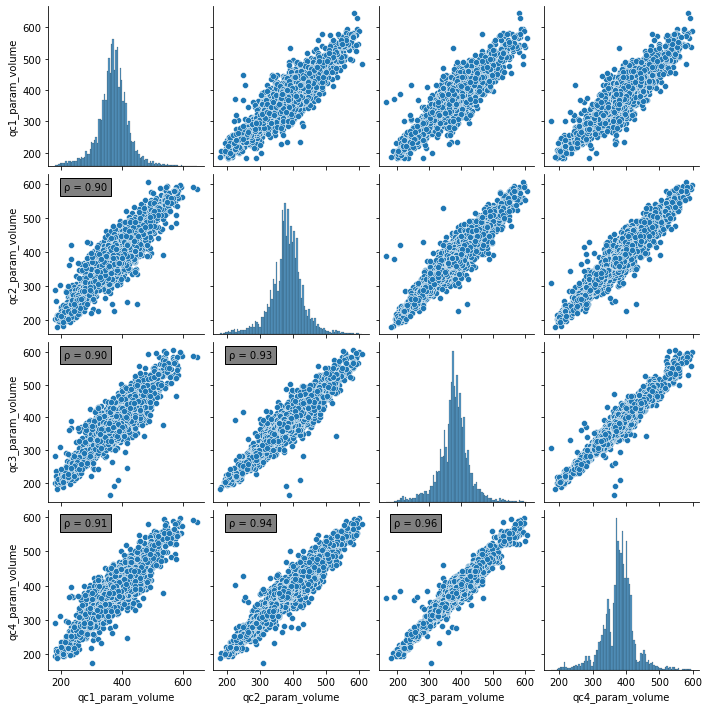

In [214]:
df_qc_vol_check = df_cleaned[["qc1_param_volume", "qc2_param_volume", "qc3_param_volume", "qc4_param_volume"]]
df_qc_vol_check = df_qc_vol_check[(df_qc_vol_check>150) & (df_qc_vol_check<700)]
df_qc_vol_check.dropna(axis=0, inplace=True)
df_qc_vol_check.reset_index(drop=True, inplace=True)

# CREATE PAIRPLOT TO SHOW CORRELATIONS OF DIFFERENT QC VOLUME STEPS
# DISPLAY CORRELATION (Pearson) IN RESPECTIVE PLOTS

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    text = ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    text.set_bbox(dict(facecolor='grey', edgecolor='k'))

p = sns.pairplot(df_qc_vol_check)
p.map_lower(corrfunc)
plt.show()

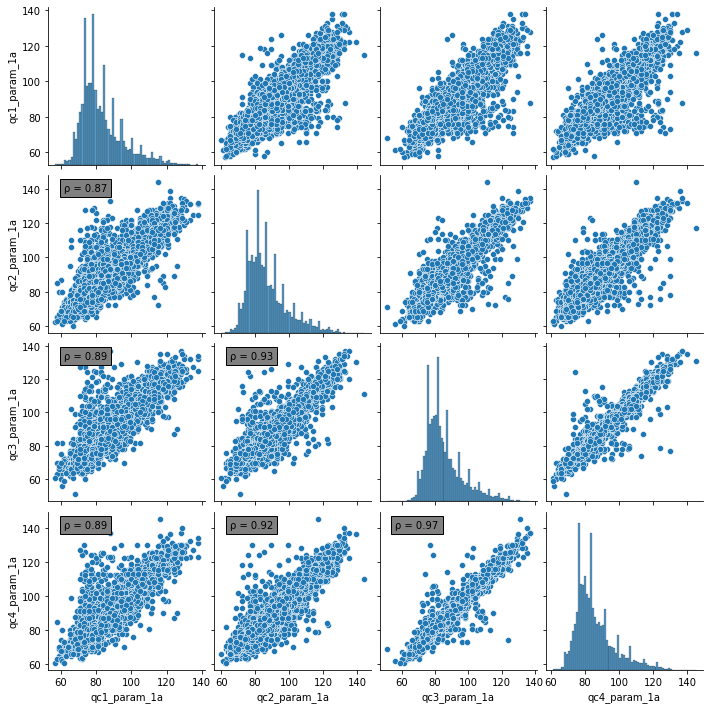

In [215]:
df_qc_vol_check = df_cleaned[["qc1_param_1a", "qc2_param_1a", "qc3_param_1a", "qc4_param_1a"]]
df_qc_vol_check = df_qc_vol_check[(df_qc_vol_check>50) & (df_qc_vol_check<170)]
df_qc_vol_check.dropna(axis=0, inplace=True)
df_qc_vol_check.reset_index(drop=True, inplace=True)

# CREATE PAIRPLOT TO SHOW CORRELATIONS OF DIFFERENT QC VOLUME STEPS
# DISPLAY CORRELATION (Pearson) IN RESPECTIVE PLOTS

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    text = ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    text.set_bbox(dict(facecolor='grey', edgecolor='k'))

p = sns.pairplot(df_qc_vol_check)
p.map_lower(corrfunc)
plt.show()

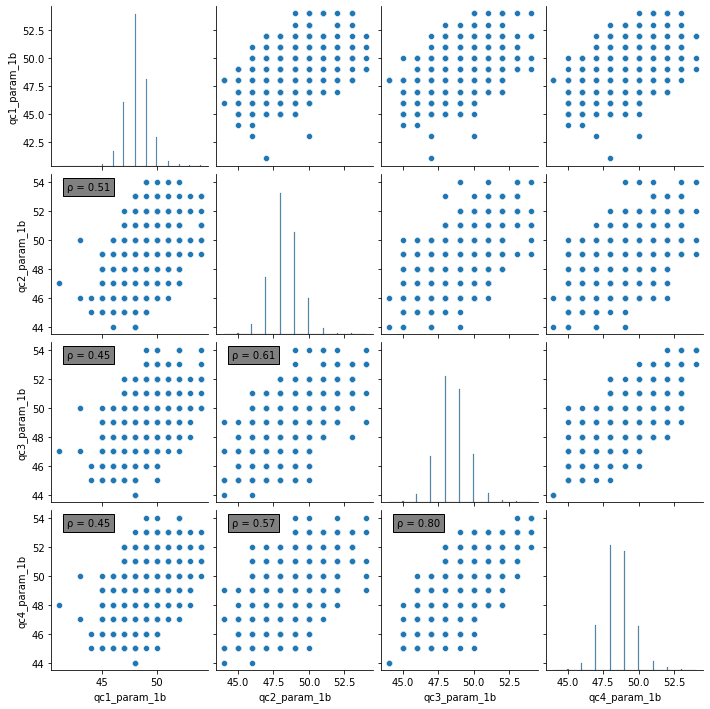

In [216]:
df_qc_vol_check = df_cleaned[["qc1_param_1b", "qc2_param_1b", "qc3_param_1b", "qc4_param_1b"]]
df_qc_vol_check = df_qc_vol_check[(df_qc_vol_check>40) & (df_qc_vol_check<55)]
df_qc_vol_check.dropna(axis=0, inplace=True)
df_qc_vol_check.reset_index(drop=True, inplace=True)

# CREATE PAIRPLOT TO SHOW CORRELATIONS OF DIFFERENT QC VOLUME STEPS
# DISPLAY CORRELATION (Pearson) IN RESPECTIVE PLOTS

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    text = ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    text.set_bbox(dict(facecolor='grey', edgecolor='k'))

p = sns.pairplot(df_qc_vol_check)
p.map_lower(corrfunc)
plt.show()

**`OBSERVATION / DESCRIPTION`**

- qc volume parameters are strongly correlated (>= 0.9)
- qc voltage parameters are strongly correlated (>= 0.87)
- qc pulse parameters are less strongly correlated (>= 0.45)
    - nature of pulse values (whole numbers betwen ~ 40-55) makes them appear discrete
    - they will be used as numerical feature though

*Different qc parameters will be aggregated to condense features into single (target) feature!* <br>

Initial round of model creation aims at predicting qc volume. <br>
It is also planned to use geometric parameter + qc volume to predict voltage and pulse.

**`AGGREGATE (AVERAGE) VOLUME, VOLTAGE, PULSE`**

In [217]:
# AVG ALL QC_VOLUMEs TO YIELD SINGLE TARGET FEATURE
qc1_vol = df_cleaned["qc1_param_volume"]
qc2_vol = df_cleaned["qc2_param_volume"]
qc3_vol = df_cleaned["qc3_param_volume"]
qc4_vol = df_cleaned["qc4_param_volume"]

# AVG ALL QC_VOLTAGEs
qc1_voltage = df_cleaned["qc1_param_1a"]
qc2_voltage = df_cleaned["qc2_param_1a"]
qc3_voltage = df_cleaned["qc3_param_1a"]
qc4_voltage = df_cleaned["qc4_param_1a"]

# AVG ALL QC_PULSEs
qc1_pulse = df_cleaned["qc1_param_1b"]
qc2_pulse = df_cleaned["qc2_param_1b"]
qc3_pulse = df_cleaned["qc3_param_1b"]
qc4_pulse = df_cleaned["qc4_param_1b"]

qc_volumes = list(zip(qc1_vol, qc2_vol, qc3_vol, qc4_vol))
qc_voltages = list(zip(qc1_voltage, qc2_voltage, qc3_voltage, qc4_voltage))
qc_pulses = list(zip(qc1_pulse, qc2_pulse, qc3_pulse, qc4_pulse))

qc_volume_means = [np.nanmean(volume) for volume in qc_volumes]
qc_voltage_means = [np.nanmean(voltage) for voltage in qc_voltages]
qc_puls_means = [np.nanmean(puls) for puls in qc_pulses]

# ADD NEW QC_MEAN COLUMNS TO DF
df_cleaned["qc_volume_mean"] = qc_volume_means
df_cleaned["qc_param_1a_mean"] = qc_voltage_means
df_cleaned["qc_param_1b_mean"] = qc_puls_means

# DROP SPECIFIC QC VOLUME, VOLTAGE, PULS COLUMNS & ONLY KEEP AVERAGED COLS
df_cleaned.drop(columns=["qc1_param_volume", "qc2_param_volume", "qc3_param_volume","qc4_param_volume",
                        "qc1_param_1a","qc2_param_1a","qc3_param_1a","qc4_param_1a",
                        "qc1_param_1b","qc2_param_1b","qc3_param_1b","qc4_param_1b"], inplace=True)

In [218]:
# GET NUMERICAL FEATURES FROM DATAFRAME
df_numerical_temp = df_cleaned.select_dtypes(include=np.number)

# DROP CATEGORICAL FEATURES FROM NUMERICAL DATAFRAME
df_numerical_temp.drop(columns=["production_size", "p_misc_phase", "product_kind", "product_family",
                          "misc_take_1","misc_take_2"], inplace=True)

sns.pairplot(df_numerical_temp)

## Dropping outliers / NaNs by trimming / pruning values to specific ranges
*Specific ranges are based on given production thresholds*

In [219]:
# DROP ROWS WHERE QC VOLUME, VOLTAGE, PULSE IS BELOW/ABOVE CRITICAL, SENSIBLE THRESHOLD
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["g_param_2a"]>0) &
                       (df_cleaned["g_param_2a"]<=100)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["g_param_2b"]>0) &
                       (df_cleaned["g_param_2b"]<=90)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["g_param_3d"]>0) &
                       (df_cleaned["g_param_3d"]<=7)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["g_param_3e"]>=29) &
                       (df_cleaned["g_param_3e"]<=37)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["g_param_3a"]>=0) &
                       (df_cleaned["g_param_3a"]<=1.4)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["g_param_3b"]>0) &
                       (df_cleaned["g_param_3b"]<=1.2)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["g_param_3c"]>=0) &
                       (df_cleaned["g_param_3c"]<=4)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["g_param_4"]>=30) &
                       (df_cleaned["g_param_4"]<=70)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["qc_volume_mean"]>=150) &
                       (df_cleaned["qc_volume_mean"]<=650)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["qc_param_1a_mean"]>=50) &
                       (df_cleaned["qc_param_1a_mean"]<=170)]
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["qc_param_1b_mean"]>=40) &
                       (df_cleaned["qc_param_1b_mean"]<=55)]

df_cleaned.reset_index(drop=True, inplace=True)
print(len(df_cleaned))

104702
103175
103101
55270
53508
50777
48955
48926
37627
27971
27373
27010


## Splitting numerical and categorical data

In [266]:
# TAKE CATEGORICAL FEATURES FROM DATAFRAME
df_categorical = df_cleaned[["production_size", "p_misc_phase", "product_kind", 
                             "product_family","misc_take_1","misc_take_2"]]

In [270]:
df_categorical[df_categorical["p_misc_phase"]<0]

production_size  p_misc_phase  product_kind  product_family  \
16315             4.00        -22.05             1               1   
16330             4.00         -5.54             1               1   

       misc_take_1  misc_take_2  
16315         2.00         2.00  
16330         2.00         2.00

In [274]:
df_prod_whole.columns

Index(['PDC_Nummer', 'Produktion_Groesse', 'Familie', 'Art',
       'Kommentar_Produktion', 'Grenzwert-Set', 'Defekt_Arbeitsschritt_ID',
       'Defekt_Grund_ID', 'Schmelzen_Personal', 'Schmelzen_Datum',
       ...
       'Piezo_ID', 'NS2_Linear_Factor', 'Kleben1_Shore', 'BQC_KopfID',
       'BQC_Kanal', 'BQC_Version', 'Versand_Intern', 'WT1_KopfID', 'WT1_Kanal',
       'WT1_Version'],
      dtype='object', length=195)

In [275]:
df_prod_whole[df_prod_whole["Produktion_Groesse"]==11]

PDC_Nummer  Produktion_Groesse  Familie  Art Kommentar_Produktion  \
2301       161983               11.00        2    1                 SG 2   
2303       161981               11.00        2    1                 SG 2   
2308       161976               11.00        2    1                 SG 2   
2311       161973               11.00        2    1                 SG 2   
2312       161972               11.00        2    1                 SG 2   
...           ...                 ...      ...  ...                  ...   
76805       80476               11.00        2    7                  NaN   
76856       80425               11.00        2    7                  NaN   
76872       80409               11.00        2    7                  NaN   
76905       80376               11.00        2    8                  NaN   
76907       80374               11.00        2    7                  NaN   

       Grenzwert-Set  Defekt_Arbeitsschritt_ID  Defekt_Grund_ID  \
2301               1                      1.00             1.00   
2303               1                      9.00            15.00   
2308               1                      1.00             1.00   
2311               1                      1.00             1.00   
2312               1                      1.00             1.00   
...              ...                       ...              ...   
76805              1                     15.00             5.00   
76856              1                     13.00            17.00   
76872              1                     19.00            26.00   
76905              1                     17.00             9.00   
76907              1                     13.00            17.00   

      Schmelzen_Personal Schmelzen_Datum Schmelzen_Ort  Schmelzen_Geraet  \
2301                 RAP      2022-07-25        Berlin              2.00   
2303                 RAP      2022-07-25        Berlin              2.00   
2308                 RAP      2022-07-25        Berlin              2.00   
2311                 RAP      2022-07-25        Berlin              2.00   
2312                 RAP      2022-07-25        Berlin              2.00   
...                  ...             ...           ...               ...   
76805                 EL      2020-04-07        Berlin              4.00   
76856                 EL      2020-04-07        Berlin              4.00   
76872                 EL      2020-04-06        Berlin              4.00   
76905                 EL      2020-04-03        Berlin              4.00   
76907                 EL      2020-04-03        Berlin              4.00   

       Schmelzen_Kapillaren-Charge NS1_Personal   NS1_Datum NS1_Ort  \
2301                             1          RAP  2022-07-26  Berlin   
2303                             1          RAP  2022-07-26  Berlin   
2308                             1          RAP  2022-07-26  Berlin   
2311                             1          RAP  2022-07-26  Berlin   
2312                             1          RAP  2022-07-26  Berlin   
...                            ...          ...         ...     ...   
76805                            1           EL  2020-04-08  Berlin   
76856                            1           EL  2020-04-07  Berlin   
76872                            1           EL  2020-04-07  Berlin   
76905                            1           EL  2020-04-06  Berlin   
76907                            1           EL  2020-04-06  Berlin   

       NS1_Geraet NS1_Winkel_vorne NS1_Winkel_hinten NS1_Durchmesser_vorne  \
2301         1.00               39                 3                    43   
2303         1.00               14                 9                  43,5   
2308         1.00               24                41                  45,5   
2311         1.00               23                 1                  43,4   
2312         1.00               19                17                  41,9   
...           ...              ...               ...   

In [269]:
df_categorical.describe()

production_size  p_misc_phase  product_kind  product_family  \
count         26527.00      22364.00      27010.00        27010.00   
mean              4.68         76.15          3.43            1.00   
std               1.34        115.20          2.78            0.00   
min               1.00        -22.05          1.00            1.00   
25%               4.00         68.74          1.00            1.00   
50%               5.00         74.87          1.00            1.00   
75%               5.00         77.45          7.00            1.00   
max              11.00       7761.00          8.00            1.00   

       misc_take_1  misc_take_2  
count     26526.00     26526.00  
mean          1.99         2.06  
std           0.99         1.10  
min           0.00         0.00  
25%           1.00         1.00  
50%           2.00         2.00  
75%           3.00         3.00  
max          11.00        11.00

## Processing NaN values - Categoricals

### Fill NaN values with mode in respective personal columns

### Fill missing place with P distribution, where 67% of the time the product comes from Berlin

df_categorical["schmelzen_ort"].fillna(random.choices(['Berlin', 'Dortmund'], 
                                                      weights=[0.67, 0.33], k=1)[0], inplace=True)

### Fill NaN values of produktion_groesse with static value 1

df_categorical["produktion_groesse"].fillna(1, inplace=True)

### Fill NaN kleben1_kleber_teilentnahme with average of non-zero entries
*min = 0; max = 5 --> based on procedural limits*

df_categorical["kleben1_kleber_teilentnahme"].fillna(int(np.mean(
    [int(k1e) for k1e in list(df_categorical["kleben1_kleber_teilentnahme"].unique()) if 6 > k1e > 0])), inplace=True)

### Fill NaN kleben2_kleber_teilentnahme with average of non-zero entries
*min = 0; max = 6 --> based on procedural limits*

df_categorical["kleben2_kleber_teilentnahme"].fillna(
    int(np.mean([int(k1e) for k1e in list(df_categorical["kleben2_kleber_teilentnahme"].unique()) if 7 > k1e > 0])), inplace=True)

### Fill NaN piezo_phase with average of non-zero entries

def get_numerical(df):
    
    df_edanum = df_cleaned.select_dtypes(include=np.number)

    ns1_cols = [col for col in df_edanum.columns if "ns1" in col if 'geraet' not in col]
    ns2_cols = [col for col in df_edanum.columns if "ns2" in col if 'geraet' not in col]
    piezo_cols = [col for col in df_edanum.columns if "piezo" in col]
    oeo_cols=[col for col in df_edanum.columns if "oeo" in col]
    vol_cols = [col for col in df_edanum.columns if "volume" in col]
    span_cols =[col for col in df_edanum.columns if "spannung" in col]
    pulse_col = [col for col in df_edanum.columns if "puls" in col]

    columns_to_use = ns1_cols + ns2_cols + piezo_cols + oeo_cols + span_cols + pulse_col + vol_cols

    df_numerical = df_edanum[columns_to_use]
    
    df_numerical.rename(columns={'bqc_volumen': 'qc1_volumen', 
                                 'et1_volumen': 'qc2_volumen',
                                'ft1_volumen': 'qc3_volumen',
                                'ek_volumen': 'qc4_volumen',
                                 
                                'bqc_spannung': 'qc1_spannung', 
                                 'et1_spannung': 'qc2_spannung',
                                'ft1_spannung': 'qc3_spannung',
                                'ek_spannung': 'qc4_spannung',
                                 
                                'bqc_puls': 'qc1_puls', 
                                 'et1_puls': 'qc2_puls',
                                'ft1_puls': 'qc3_puls',
                                'ek_puls': 'qc4_puls'}, inplace=True)
    
    return df_numerical

def get_categorical(df):
    df_categorical = df_cleaned.select_dtypes(include=['object'])
    
    cols_categorical = ["familie", 
                        'schmelzen_personal', "schmelzen_ort", 
                        'ns1_personal', 'schneiden_personal', 'schleifen_personal',
                        'ns2_personal', 'oeo_personal', 
                        'kleben1_personal', 'kleben2_personal',
                        'bqc_personal', 'et1_personal', 'ft1_personal', 'ek_personal']
    
    df_categorical = df_categorical[cols_categorical]
    
    df_categorical["produktion_groesse"] = df_cleaned["produktion_groesse"]
    df_categorical["art"] = df_cleaned["art"]
    df_categorical["kleben1_kleber_teilentnahme"] = df_cleaned["kleben1_kleber_teilentnahme"]
    df_categorical["kleben2_kleber_teilentnahme"] = df_cleaned["kleben2_kleber_teilentnahme"]

    return df_categorical

#df_numerical = get_numerical(df_cleaned)
#df_categorical = get_categorical(df_cleaned)

In [220]:
# GET NUMERICAL FEATURES FROM DATAFRAME
df_numerical = df_cleaned.select_dtypes(include=np.number)

# DROP CATEGORICAL FEATURES FROM NUMERICAL DATAFRAME
df_numerical.drop(columns=["production_size", "p_misc_phase", "product_kind", "product_family",
                          "misc_take_1","misc_take_2"], inplace=True)

## Check multicollinearity for numerical features

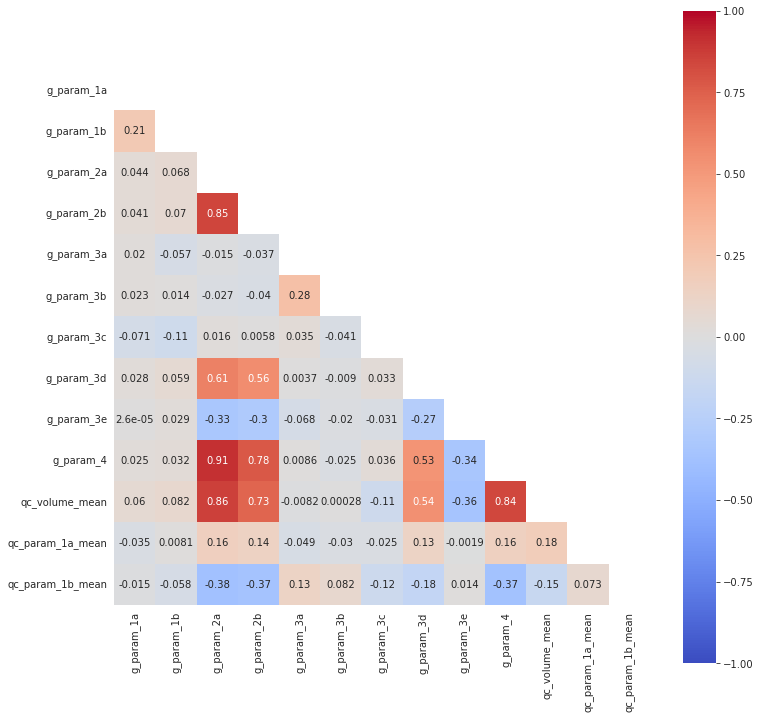

In [221]:
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [222]:
def show_and_drop_high_correlation_features(df, threshold):
    """
    Show any features that have correlation higher than threshold with any other;
    """
    corr_matrix=df.corr().abs()
    upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    
    cols_above_threshold = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    cols_above_threshold = [col for col in cols_above_threshold if "volume" not in col]
    df = df.drop(columns=cols_above_threshold)
    return df

df_numerical = show_and_drop_high_correlation_features(df_numerical, 0.8)

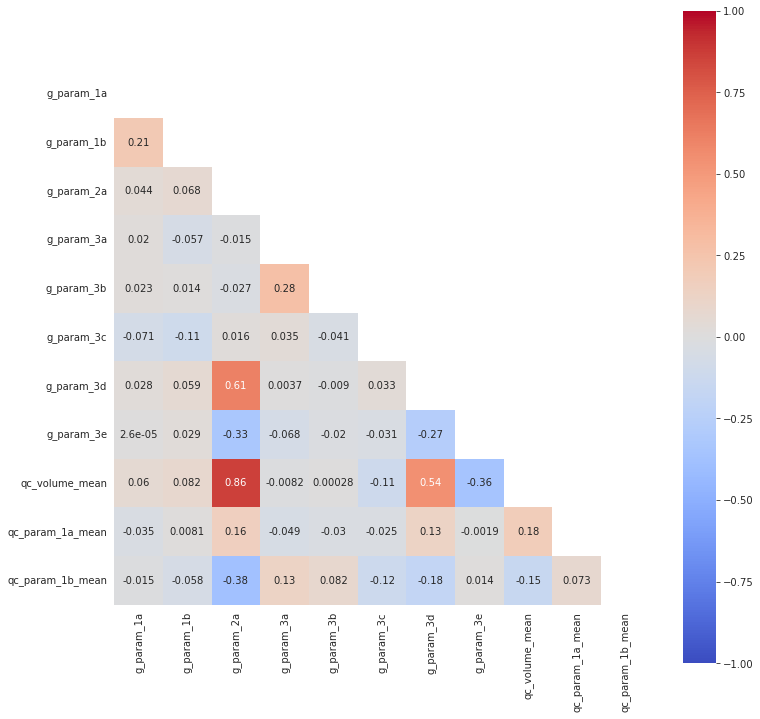

In [223]:
corr_matrix = df_numerical.corr()
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Hot-Encode categorical features

#df_complete_BQC_categorical_hotcoded = pd.get_dummies(df_complete_BQC_categorical, drop_first=True)

df_categorical_hotcoded = pd.get_dummies(df_categorical, drop_first=True)


# Linear Regression

df_numerical_categorical = pd.concat((df_categorical_hotcoded, df_numerical), axis=1)

df_numerical_categorical = df_numerical_categorical[df_numerical_categorical["qc_vol_mean"]>0].reset_index(drop=True)

#df_numerical_categorical.dropna(axis=0, inplace=True)

## X-y Split

In [224]:
#df_to_use = df_numerical_complete_BQC_categorical
print("Rows before dropping NaN values: ", len(df_numerical))
df_to_use = df_numerical.dropna(axis=0)
print("Rows after dropping NaN values: ", len(df_to_use))

Rows before dropping NaN values:  27010
Rows after dropping NaN values:  27010


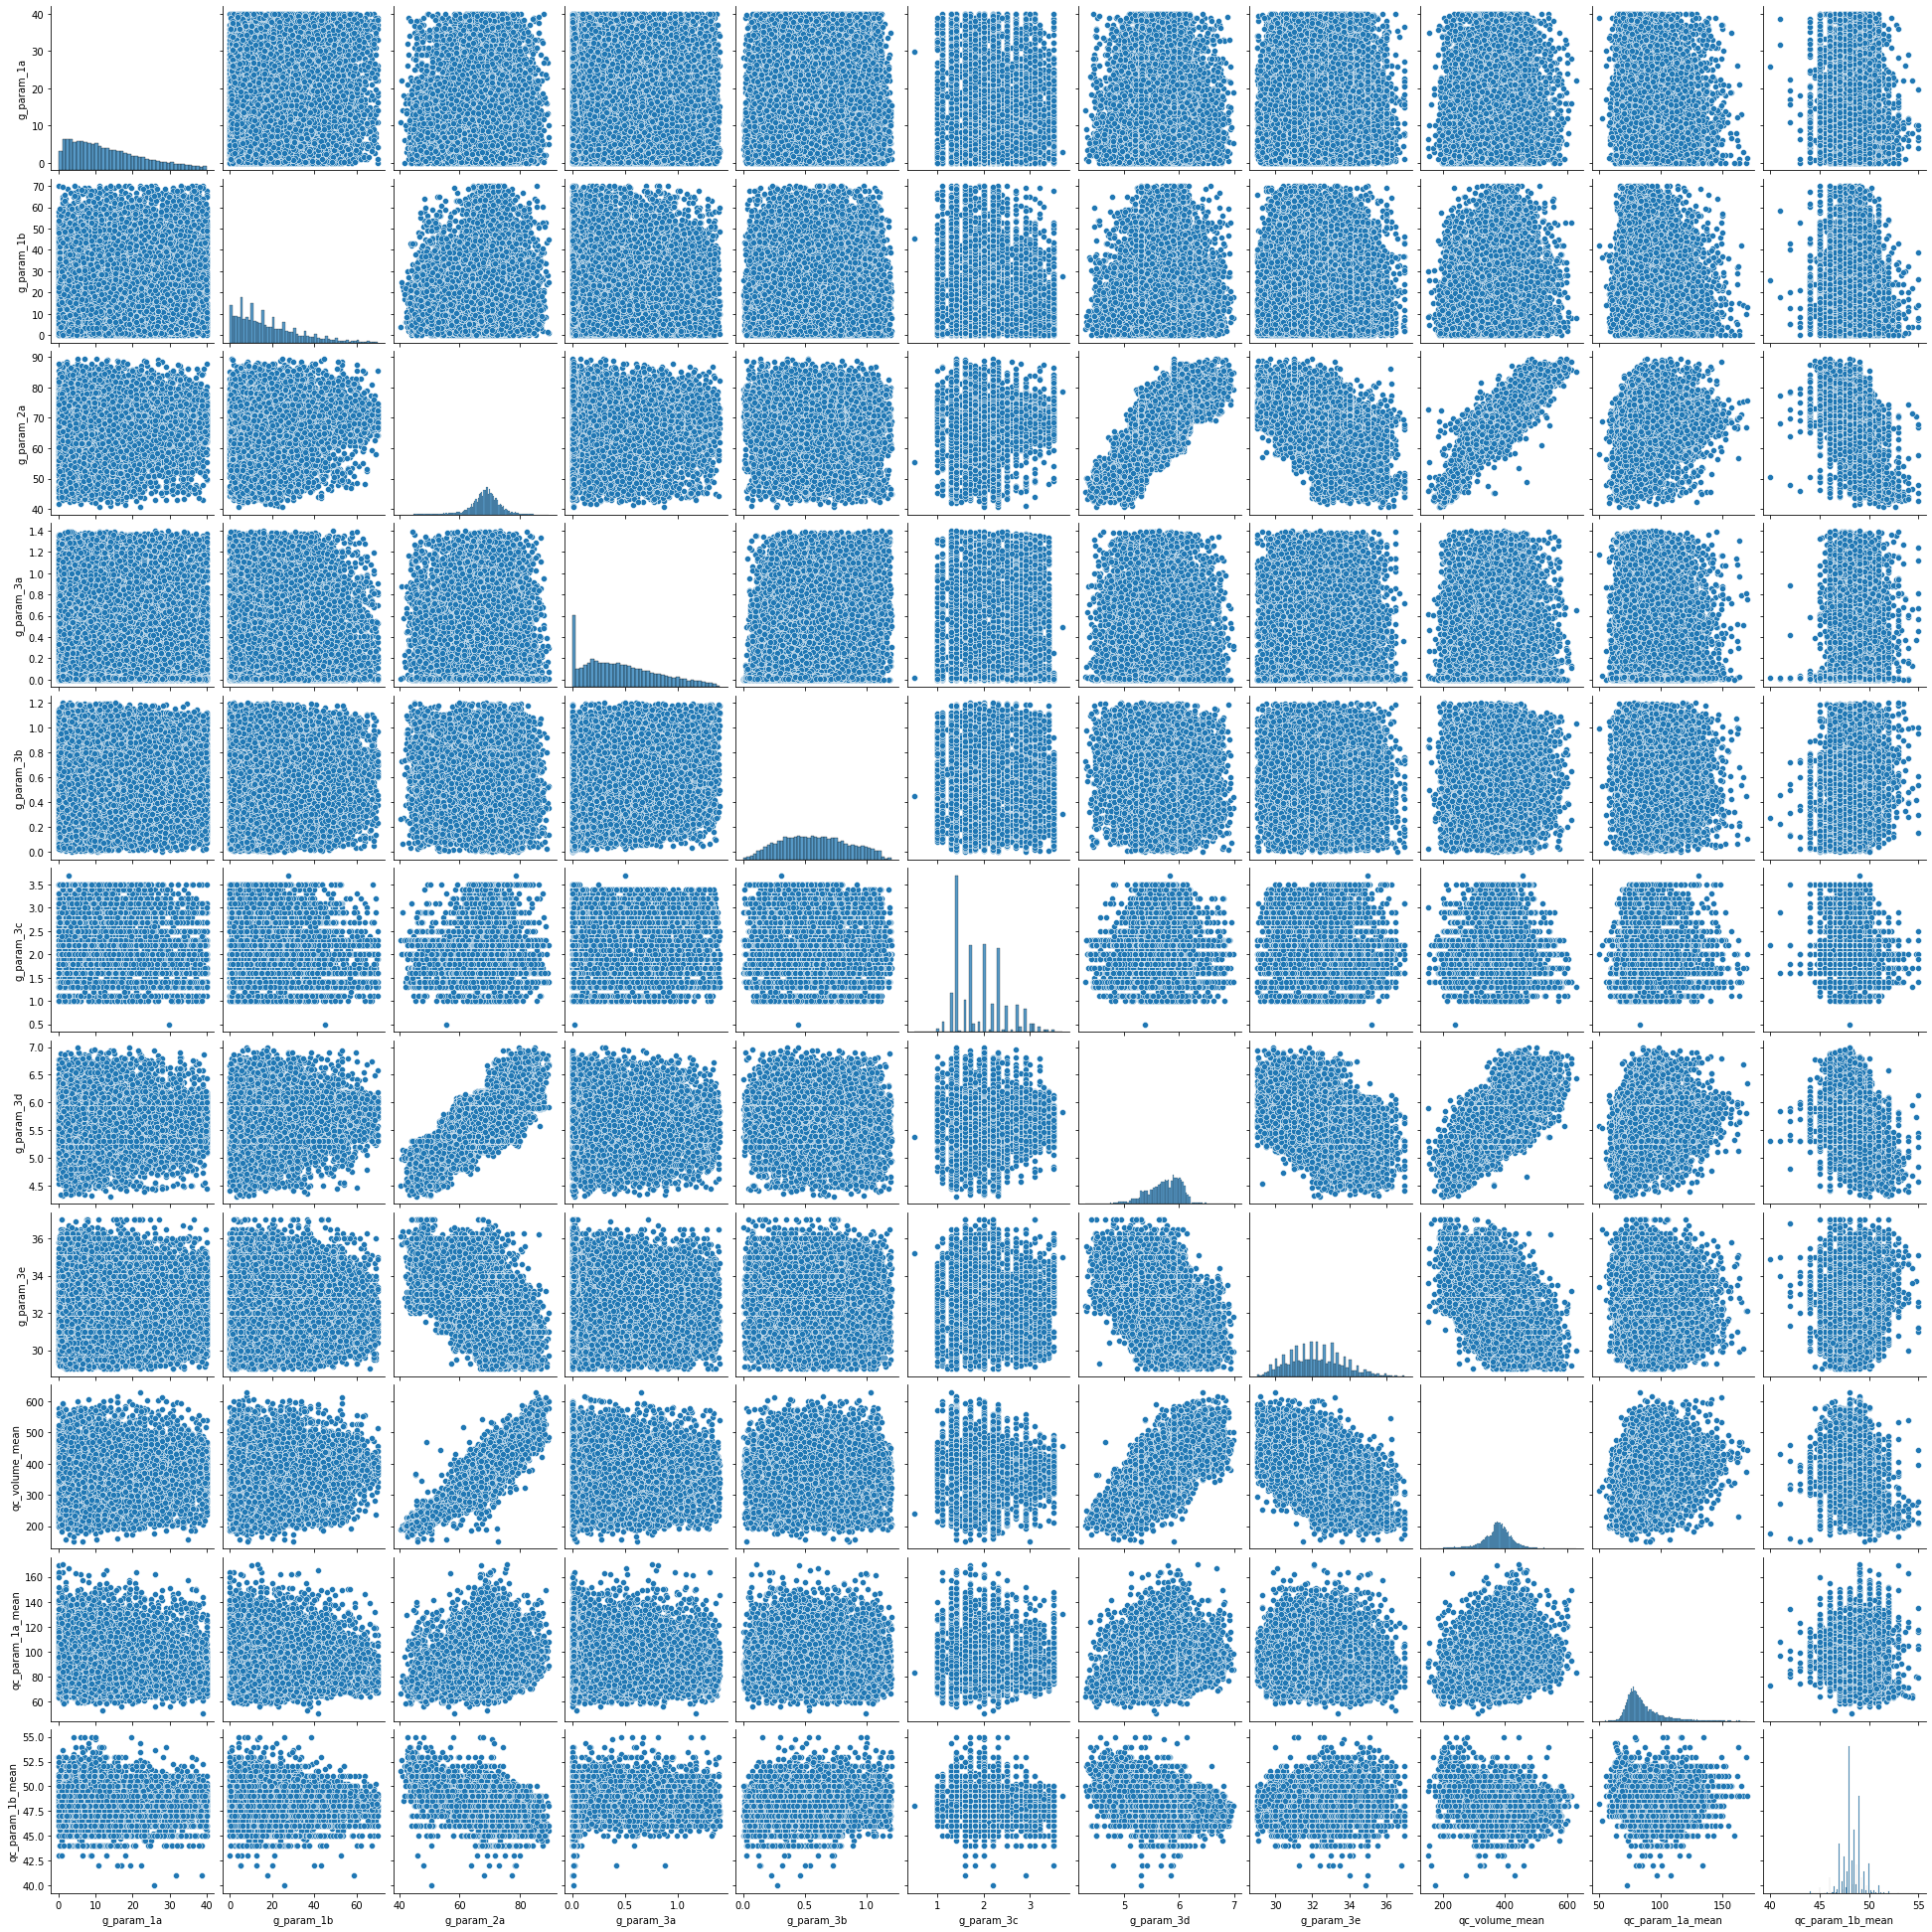

In [225]:
sns.pairplot(df_to_use)
fig.savefig("Pairplot_df_numerical_cleaned.jpg", bbox_inches="tight", dpi=300)

'produktion_groesse': "production_size",
'familie': "product_family",
'art': "product_kind",
'ns1_winkel_vorne': "g_param_1a",
'ns1_winkel_hinten': "g_param_1b",
'ns1_durchmesser_vorne': "g_param_2a",
'ns1_durchmesser_hinten': "g_param_2b",
'ns2_center_variation': "g_param_3a",
'ns2_front_angle': "g_param_3b",
'ns2_curve': "g_param_3c",
'ns2_15xlength': "g_param_3d",
'ns2_parabolic_factor': "g_param_3e",
'oeo_oeo': "g_param_4",
'kleben1_kleber_teilentnahme': "misc_take_1",
'kleben2_kleber_teilentnahme': "misc_take_2",
'bqc_spannung': "qc1_param_1a",
'bqc_puls': "qc1_param_1b",
'bqc_volumen': "qc1_param_volume",
'et1_spannung': "qc2_param_1a",
'et1_puls': "qc2_param_1b",
'et1_volumen': "qc2_param_volume",
'ft1_spannung': "qc3_param_1a",
'ft1_puls': "qc3_param_1b",
'ft1_volumen': "qc3_param_volume",
'ek_spannung': "qc4_param_1a",
'ek_puls': "qc4_param_1b",
'ek_volumen': "qc4_param_volume",
'piezo_position': "p_misc_pos",
'piezo_phase': "p_misc_phase"
qc_param_1a_mean
qc_param_1b_mean
qc_volume_mean

In [226]:
#X = df_to_use.drop('qc_volume_mean', axis=1)
X = df_to_use.drop(['qc_volume_mean', 
                    'qc_param_1a_mean', 'qc_param_1b_mean', "g_param_3c"], axis=1) #, 'qc_voltage_mean', 'qc_puls_mean'
y = df_to_use["qc_volume_mean"]

## Train - Test - Split

In [227]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3,random_state=42)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (18907, 7)
Shape X_test: (8103, 7)
Shape y_train: (18907,)
Shape y_test: (8103,)


## Standardize the data after data split

In [239]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients (betas): ", np.around(model.coef_,4))
print("Coefficients (alpha): ", np.around(model.intercept_,4))

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(18907, 7) (8103, 7)
Coefficients (betas):  [ 0.8808  1.457  43.9014 -0.3277  1.2356  0.5926 -4.4631]
Coefficients (alpha):  375.7451


qc_volume_mean = 0.8808 * g_param_1a + 1.457 * g_param_1b + 43.9014 * g_param_2a - 0.3277 * g_param_3a + 1.2356 * g_param_3b + 0.5926 * g_param_3d + -4.4631 * g_param_3e + 375.7451

## Evaluating Model Performance

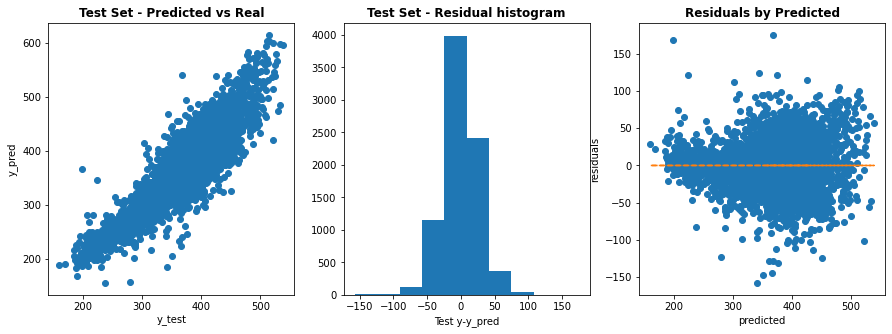

In [229]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set - Predicted vs Real", weight="bold")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set - Residual histogram", weight="bold")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted", weight="bold")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

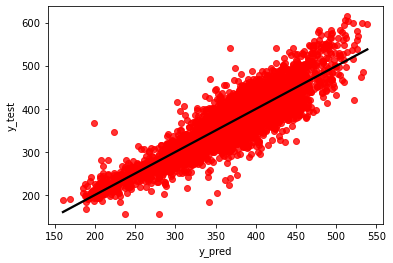

In [230]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

## Error metrics

In [231]:
mse_1 = round(mse(y_test,y_pred),2)
rmse_1 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_1 = round(mae(y_test,y_pred),2)

print("MSE:", mse_1) # shows squared error (harder to interpret)
print("RMSE:", rmse_1) # shows error
print("MAE:", mae_1) # shows real error (in $)
print("-----")

# R^2
R2_1 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_1 = round(1 - (1-R2_1)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) only> is {round(R2_1,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) only> is {round(Adj_R2_1,2)}.")

MSE: 707.96
RMSE: 26.61
MAE: 20.34
-----
R^2 for <numerical (with outliers) only> is 0.75.
Adjusted R^2 for <numerical (with outliers) only> is 0.75.


**`OBSERVATIONS`**
- When not filtering on ns2_cv and ns2_fa, R2 increases from 0.72 to 0.82
- Changing random seed has significant impact (~ +/- 0.05) on R2


- not filtering on ns2_cv / ns2_fa / ns2_curve + seed = 6969 --> R2 = 0.8
- not filtering on ns2_cv / ns2_fa / ns2_curve + seed = 42 --> R2 = 0.79
- not filterin ns2_curve + seed 6969 --> R2 = 0.78
- filtering on all + seed 6969 --> R2 = 0.76
- not filtering on qc_voltages / qc_pulses + seed 6969 --> R2 = 0.55


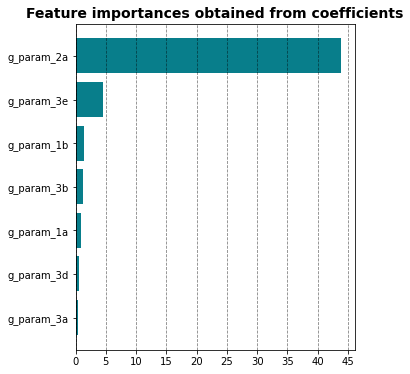

In [265]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False)
width = features_importances['Importance'][::-1]
y = features_importances['Attribute'][::-1]

fig = plt.figure(figsize=(5,6))
plt.grid(ls="--", alpha=0.5, color="k", axis="x")
plt.barh(y=y, width=width, color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=14, weight="bold")
plt.xticks(list(range(0,int(max(width)+5),5)))
plt.savefig("Feature_Importance_1.jpg", bbox_inches="tight", dpi=300)
plt.show()

# Lasso Regression